## Authors : Si Dan HO, Antoine Jacquet, Mickael Masumbuko

# Calibration du modèle de Black Scholes

# Sommaire

- Calcul d'un Call sous le modèle de Black Scholes
    - Calcul d'un Call par la formule de Black Scholes
    - Calcul d'un Call par Monte Carlo
- Calcul des Greeks
    - Formules fermées
    - Différences finies
- Calcul de la volatilité implicite
- Bonus : Calibration de la nappe de volatilité des Calls (inachevé)
    - Rappel de la fonction retournant la volatilité implicite du Call
    - Chargement des données marchés des Calls de JP Morgan 
    - Calibration de la volatilité implicite
    - Valeurs manquantes pour la volatilité implicite
    - Traçage du Smile de volatilité
- Bonus : pricing du Call par résolution numérique de l'EDP de Black Scholes
    - Transformation de l'EDP de Black Scholes en l'équation de la chaleur
    - Méthode des différences finies
    - Résolution par le schéma de Crank Nicholson
    - Schéma implicite

## Calcul d'un Call sous le modèle de Black Scholes

### Calcul d'un Call par la formule de Black Scholes

In [3]:
import time
import datetime as dt
import pandas as pd
import numpy as np
import math
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm 
import pylab as py
from scipy import interpolate

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from scipy.integrate import quad 
import random

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

Rappelons que le modèle de Black Scholes permet de valoriser des options européennes vanilles de Strike $K$, de maturité $T$, et dont le sous jacent est de type Equity de prix $(S_t)$. Ainsi, le payoff de l'option est égal à $(S_t - K)_{+}$.

Plus particulièrement, le modèle de Black Scholes stipule que la dynamique du sous-jacent sous la probabilité risque neutre est donnée par :

$$
dS_t = S_t(rdt + \sigma dW_t)
$$,

et la formule de Black Scholes permet d'établir le prix $C_t$ de l'option à l'instant $t$ de la manière suivante, dans le cas d'un Call :

$C(t,S) = C_{BS}(S_t, K,T,r,\sigma) = S \mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2)$ avec:

$d_1 = \frac{ln(S/K)+(r+\sigma^2/2)(T-t)}{\sigma \sqrt{(T-t)}}$ et

$d_2 = d_1 - \sigma \sqrt{(T-t)}$,

et $\mathcal{N}$ est la fonction de répartition d'une variable gaussienne centrée réduite.

Nous posons : $\tau = T-t$.

Pour pricer un Call, les paramètres d'entrées nécessaire pour le calcul sont :

- Prix du sous-jacent au temps t : $S_t$
- le Strike $K$
- le taux sans risque $r$
- le ténor $\tau = T-t$
- la volatilité du sous-jacent : $\sigma$.

Dans le cas d'un Put, le prix est donné soit via la formule de parité Call Put :

$$
C(t) - P(t) = S_t - Ke^{-r(T-t)}
$$

ou bien par la formule de Black Scholes :

$$
P(t,S) = P_{BS}(S_t, K,T,r,\sigma) = Ke^{-r(T-t)}\mathcal{N}(-d_2) - S \mathcal{N}(-d_1)
$$

Ainsi, l'implémentation de la formule de Black Scholes se fait comme suit dans le cas d'un Call:

In [4]:
def FormulaBS(S,K,r,tau,sigma):
    d1 = (math.log(S/K)+(r+sigma**2/2)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    C = S*sps.norm.cdf(d1) - K*math.exp(-r*tau)*sps.norm.cdf(d2)
    return C

- Supposons qu'à l'échéance de six mois, le cours de l'action sous-jacente est 42 euros, le strike est de 40, le taux d'intérêt sans risque est de 10% et la volatilité annuelle de 20%.

De ce fait, en appliquant la fonction definie ci dessus:

In [5]:
C1 = FormulaBS(42,40,0.1,0.5,0.2)
print('Le prix du Call à maturité 6 mois est égale à =%.2f' % C1)

Le prix du Call à maturité 6 mois est égale à =4.76


- Supposons qu'à l'échéance de trois mois, le cours de l'action sous-jacente est 42 euros, le strike est de 40, le taux d'intérêt sans risque est de 10% et la volatilité annuelle de 20%.

Le prix est donc :

In [6]:
C2 = FormulaBS(42,40,0.1,0.25,0.2)
print('Le prix du Call à maturité 3 mois est égale à =%.2f' % C2)

Le prix du Call à maturité 3 mois est égale à =3.53


Plus généralement, grâce à la formule de Black Scholes, il est possible de tracer le prix actuel d'un Call, en fonction du prix actuel $S_0$ du sous-jacent. 

Supposons ainsi un Call de strike 9000 et de maturité $T=2$, et dont le sous-jacent a une volatilité de 0.3 et le taux sans risque est de 0.05. Le traçage de sa valeur actuelle selon celle de son sous-jacent donne:

Text(0, 0.5, 'Valeur actuelle du Call (t=0)')

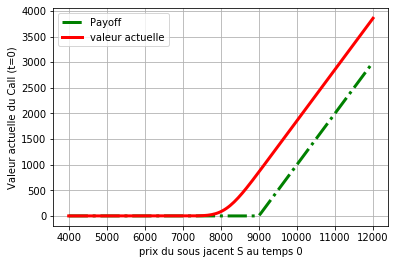

In [7]:
# Déclaration des variables
K = 9000 
T = 2.0 
r = 0.05 
vol = 0.2
 
# Calcul du prix du Strike selon BS pour divers prix du sous jacent au temps 0
S = np.linspace(4000, 12000, 150)
Payoff = np.maximum(S - K, 0)
C = [FormulaBS(S_0, K, T, r, vol) for S_0 in S]

# Plot du payoff et du prix du Call en fonction du sous jacent au temps 0
plt.figure()
plt.plot(S, Payoff, 'g-.', lw=3, label='Payoff') 
plt.plot(S, C, 'r', lw=3, label='valeur actuelle')
plt.grid(True)
plt.legend(loc=0)
plt.xlabel('prix du sous jacent S au temps 0')
plt.ylabel('Valeur actuelle du Call (t=0)')

### Calcul d'un Call par Monte Carlo

Rappelons que par le théorème fondamental de la valorisation des actifs, et sachant que le prix actualisé des actifs côtés sur le marché est une martingale sous la probabilité risque neutre, le prix d'un Call étant l'espérance de ses flux futurs actualisés sous la probabilité risque neutre, celui-ci est égal à :

$C_t = e^{-r\tau}\mathbb{E}_{\mathbb{Q}}[(S_T - K)_{+}]$ avec $\mathbb{Q}$ la probabilité risque neutre.

Par ailleurs, l'univers de Black Scholes stipule de le prix du sous-jacent suit la dynamique suivante :
$dS_t = rS_t dt + \sigma S_t dW_t$

C'est à dire que au temps T : $S_T = S_t exp[(r-\frac{\sigma^2}{2})\tau + \sigma (W_T - W_t)]$

Une manière naturelle d'exploiter cette formule serait d'appliquer la méthode de Monte Carlo. Il est connu que :

$$
\mathbb{E}[g(X_t)] = \frac{1}{M}\sum_{i=1}^{M} g(X_t^i)
$$

Par ailleurs, sous la probabilité risque neutre, $W_t$ est un mouvement brownien ce qui implique que $(W_T - W_t)_{t \geq 0}$ suit une loi normale $N(0, \tau)$ sous cette probabilité.

Ainsi, $S_T$ est de même loi que $S_t exp[(r-\frac{\sigma^2}{2})\tau + \sigma *\sqrt{\tau} Z]$ avec $Z \sim N(0,\tau)$.

De ce fait, la formule du Call peut être estimée par :

$$
\hat{C}_t \approx e^{-r\tau}*\frac{1}{M}\sum_{i=1}^{M}(S_T^i - K)_{+}
$$

La première étape de la méthode Monte Carlo est de simuler les variables $(W_T - W_t)^i$ pour $i \in [|1,M|]$.

En posant $g(x) = (S_t exp[(r-\frac{\sigma^2}{2})\tau + \sigma x] - K)_{+}$, nous avons:

$$
\hat{C}_t \approx e^{-r\tau}*\frac{1}{M}\sum_{i=1}^{M}g(W_T - W_t)
$$

La méthode de Monte Carlo est implémentée selon la fonction suivante :

In [8]:
def MCCall(S, K, r, tau, sigma, M):
    G = 0
    for i in range(M):
        G+= max(S*math.exp((r-sigma**2/2)*tau +sigma*np.random.normal(0, math.sqrt(tau))) - K, 0)
    C = (math.exp(-r*tau) * G)/M
    return C

De ce fait :

In [9]:
C1_MC_1 = MCCall(42,40,0.1,0.5,0.2, 500)
C1_MC_2 = MCCall(42,40,0.1,0.5,0.2, 5000)
C1_MC_3 = MCCall(42,40,0.1,0.5,0.2, 50000)
print('Le prix du Call à maturité 6 mois selon Monte Carlo avec 500 simulations est égale à %.2f' % C1_MC_1)
print('Le prix du Call à maturité 6 mois selon Monte Carlo avec 5000 simulations est égale à %.2f' % C1_MC_2)
print('Le prix du Call à maturité 6 mois selon Monte Carlo avec 50000 simulations est égale à %.2f' % C1_MC_3)

Le prix du Call à maturité 6 mois selon Monte Carlo avec 500 simulations est égale à 4.83
Le prix du Call à maturité 6 mois selon Monte Carlo avec 5000 simulations est égale à 4.67
Le prix du Call à maturité 6 mois selon Monte Carlo avec 50000 simulations est égale à 4.75


In [10]:
C2_MC_1 = MCCall(42,40,0.1,0.25,0.2, 500)
C2_MC_2 = MCCall(42,40,0.1,0.25,0.2, 5000)
C2_MC_3 = MCCall(42,40,0.1,0.25,0.2, 50000)
print('Le prix du Call à maturité 3 mois selon Monte Carlo avec 500 simulations est égale à %.2f' % C2_MC_1)
print('Le prix du Call à maturité 3 mois selon Monte Carlo avec 5000 simulations est égale à %.2f' % C2_MC_2)
print('Le prix du Call à maturité 3 mois selon Monte Carlo avec 50000 simulations est égale à %.2f' % C2_MC_3)

Le prix du Call à maturité 3 mois selon Monte Carlo avec 500 simulations est égale à 3.48
Le prix du Call à maturité 3 mois selon Monte Carlo avec 5000 simulations est égale à 3.56
Le prix du Call à maturité 3 mois selon Monte Carlo avec 50000 simulations est égale à 3.52


### Calcul des Greeks

### Formules fermées

rappelons que les principaux Greeks d'une option sont :

$\Delta = \frac{\partial C}{\partial S} = N(d_1) > 0$

$\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{1}{S\sigma \sqrt{T-t}}*\frac{e^{-d_1^2/2}}{\sqrt{2\pi}}$

$V = \frac{\partial C}{\partial \sigma} = s \sqrt{T-t} \frac{e^{-d_1^2/2}}{\sqrt{2\pi}} > 0$

Le calcul des formules fermées ci dessus s'obtient via la fonction suivante :

In [11]:
def FormulaBSGreeks(S,K,r,tau,sigma) :
    d1 = (math.log(S/K)+(r+sigma**2/2)*tau)/(sigma*math.sqrt(tau))
    Delta = sps.norm.cdf(d1)
    Gamma = (1/(S*sigma*math.sqrt(tau)))*(math.exp(-d1**2/2))/math.sqrt(2*math.pi)
    Vega = (S*math.sqrt(tau))*sps.norm.pdf(d1)
    return (Delta, Gamma, Vega)

Ainsi, pour une option dont le sous jacent vaut 100 euros, le strike est de 110 euros, le taux sans risque est de 0.1, l'échéance est de six mois, et la volatilité est de 0.2, les Greeks du Call en questions sont :

In [12]:
Delta, Gamma, Vega = FormulaBSGreeks(100,110,0.1,0.5,0.2)
print('Delta =%.3f, Gamma =%.3f, Vega =%.3f' % (Delta, Gamma, Vega))

Delta =0.401, Gamma =0.027, Vega =27.344


### Différences finies

Les formules fermées ne pouvant pas forcément être trouvées explicitement, les Greeks doivent être approximées. Sachant que ce sont les dérivées partielles du prix du Call en fonction des divers facteurs de risques (Sous Jacent et volatilité), la méthode numérique la plus adéquate est celle des différences finies de type centré.

Prenons par exemple le Delta du Call. Dans ce cas, en posant $C(t, S)$ le prix du Call, nous avons : $\Delta_t \approx \frac{C(t, S+h) - C(t, S-h)}{2h}$. Ce résultat peut être démontré via un développement de Taylor du premier ordre.

Concernant son Gamma, nous avons : $\Gamma_t \approx \frac{C(t, S+h) + C(t, S-h) - 2C(t,S)}{h^2}$.

La valeur de $h$ doit être suffisamment petit pour avoir une approximation correcte des Greeks, mais pas trop car cela peut amener à des valeures instables en cas d'erreurs de données, qui sont dans ce cas amplifié. (Cela est considéré comme un problème de calibration.

En utilisant la formule de Black Scholes pour le prix du Call, la fonction implémentant les Greeks selon les différences finies est :

In [13]:
def DiffiniesGreeks(S,K,r,tau,sigma, h) :
    Delta = (FormulaBS(S+h,K,r,tau,sigma) - FormulaBS(S-h,K,r,tau,sigma))/(2*h)
    Gamma = (FormulaBS(S+h,K,r,tau,sigma) + FormulaBS(S-h,K,r,tau,sigma) - 2*FormulaBS(S,K,r,tau,sigma))/(h**2)
    Vega = (FormulaBS(S,K,r,tau,sigma+h) - FormulaBS(S,K,r,tau,sigma-h))/2*h
    return (Delta, Gamma, Vega)

En utilisant le même type de Call que celui défini précédemment dans le calcul des Greeks selon les formules fermées, les Greeks calculés en différences finies sont, en posant $h = 0.1$:

In [14]:
Delta, Gamma, Vega = FormulaBSGreeks(100,110,0.1,0.5,0.2)
print('Delta en différences finies =%.3f, Gamma en différences finies =%.3f, Vega en différences finies =%.3f' % (Delta, Gamma, Vega))

Delta en différences finies =0.401, Gamma en différences finies =0.027, Vega en différences finies =27.344


### Calcul de la volatilité implicite

La volatilité est l'unique paramètre inobservable dans le modèle de Black Scholes. Ainsi, la volatilité implicite est la volatilité du Call calibrée sur le modèle de Black Scholes afin que le prix du Call issu du modèle puisse coller avec celui observé sur le marché, que l'on note $C$.

Si l'on considère le prix du Call établi par la formule de Black Scholes comme fonction de la volatilité du sous-jacent, noté $C^{BS}(\sigma)$, nous avons : 

$lim_{\sigma \rightarrow 0} C^{BS}(\sigma) = (S_t - Ke^{-r(T-t)})_{+}$ et $lim_{\sigma \rightarrow \infty} C^{BS}(\sigma) = S_t$

De plus, $V = \frac{\partial C^{BS}}{\partial \sigma} = s \sqrt{T-t} \frac{e^{-d_1^2/2}}{\sqrt{2\pi}} > 0$.

Ainsi, l'équation $C^{BS}(\sigma) = C$ a une unique solution par monotonie de la fonction $C^{BS}$, sous réserve que C vérifie les contraintes d'arbitrages : $(S_t - Ke^{-r(T-t)})_{+} \leq C \leq S_t$ (contraintes démontrées par le calcul du signe de la dérivée seconde $\frac{\partial^2 C^{BS}}{\partial \sigma^2}$, et qui confirme la convexité de la fonction dans les bornes d'arbitrages).

Une autre explication de l'unicité de la solution serait que le Veja de l'option est toujours strictement positive, garantissant ainsi que le prix d'un Call est une fonction strictement croissante de la volatilité : $C(\sigma)$. En observant un prix de marché d'un certain Call (sous condition d'absence d'opportunité d'arbitrage), il est naturel de retrouver une unique volatilité implicite via la bijectivité de la fonction.

De ce fait, il est possible de retrouver la volatilité implicite via l'algorithme de Newton : 

$$
\sigma_0 = \sqrt{\frac{2|log(m)|}{T-t}}, m = \frac{S_t}{Ke^{-r(T-t)}}
$$
$$
\sigma_{n+1} = \sigma_n + \frac{C - C^{BS}(\sigma_n)}{\frac{\partial C^{BS}}{\partial \sigma}(\sigma_n)}
$$

Cette algorithme est implémentée comme suit :

In [15]:
def ImpliedVolBS(S,K,r,tau,Call, N):
    m = S/K*math.exp(-r*tau)
    sigma = math.sqrt(2*abs(math.log(m))/tau)
    for i in range(N):
        d1 = (math.log(S/K)+(r+sigma**2/2)*tau)/(sigma*math.sqrt(tau))
        Vega = (S*math.sqrt(tau))*(math.exp(-d1**2/2))/math.sqrt(2*math.pi)
        sigma+= (Call - FormulaBS(S,K,r,tau,sigma))/Vega
    return sigma

Pour une option d'achat à la monnaie d'échéance 3 mois valant 4.58 euros sur le marché sachant que $S_0 = 100$ et $r=5%$, la volatilité implicite est :

In [16]:
Vol_imp = ImpliedVolBS(100,100,0.05,0.25,4.58, 20)
print('La volatilité implicite est égale à %.10f' % Vol_imp)

La volatilité implicite est égale à 0.1982183263


Pour une option d'achat à la monnaie d'échéance 6 mois valant 4.58 euros sur le marché sachant que $S_0 = 100$ et $r=5%$, la volatilité implicite est :

In [17]:
Vol_imp = ImpliedVolBS(100,100,0.05,0.5,4.58, 20)
print('La volatilité implicite est égale à %.10f' % Vol_imp)

La volatilité implicite est égale à 0.1147074026


Cependant, lorsque la valeur du Call C observée sur le marché est trop proche des bornes d'arbitrages définiées précédemment, l'algorithme de Newton peut donner des valeurs instables. Dans ce cas, la méthode de bissection sur la fonction : $x \rightarrow C^{BS}(\frac{x}{1-x})$.

### Bonus : Calibration de la nappe de volatilité des Calls (inachevé)

Une des limites du modèle de Black Scholes est que la volatilité du sous-jacent et donc de l'option est supposée constante,  ce qui est une hypothèse trop forte puisque la volatilité peut avoir une dynamique propre à elle et que l'on observe des phénomènes de Volatility Clustering liées à des évènements tels que les Krachs Boursiers. Cela a été observé lors du Krach boursier de Wall Street en 1987. Les rendements du sous-jacent ne sont en réalité pas Gaussienne, ont une distribution à queue épaisse et ne sont pas i.i.d. L'hypothèse stipulant que le sous-jacent suit un mouvement brownien géométrique st donc remis en cause. Cela implique ainsi une Volatilité implicite qui est en réalité aléatoire et donc non constante.

Le phénomène qui illustre parfaitement cette limite du modèle concerne celle du Smile de volatilité, ou plus généralement de la nappe de volatilité. En effet, la volatilité est en réalité une fonction du Strike $K$ et de la maturité $T$. Ainsi, elle est exprimée sous la forme $\sigma(K,T)$. Or le modèle de Black Scholes suppose une volatilité constante. Ainsi, si le modèle était juste, nous aurions eu $\sigma(K,T) = \sigma$ pour tout $(K,T)$, ce qui n'est pas le cas.

Cela peut par ailleurs être appuyé par le fait que l'on trouve des prix de Call différents sur le marché en fonction du Strike $K$ et de la maturité $T$.

Pour une certaine maturité $T$, la volatilité implicite est élevée pour les Calls dont le strike $K$ est petit. Plus celui ci augmente, plus la volatilité diminue, ce qui illustre le phénomène de Volatility Skew. Cependant, pour des Call à très grands strikes, il se peut que cette volatilité augmente à nouveau. Il s'agit ici du Smile de volatilité. Plus précisément, la volatilité implicite du Call est au plus bas lorsque celui-ci est à la monnaie, et elle augmente au fur et à mesure que le Call s'éloigne de la monnaie.

Par ailleurs, la volatilité implicite est souvent bien plus élevée pour des Calls de maturité courtes que celles de maturité longues. Plus précisément, le phénomène du Smile est davantage marqué pour les options à courtes maturités que pour les longues. Cela est particulièrement vraie en cas de période stressée du fait de l'incertitude sur les marchés ainsi que du caractère risque-adverse des agents. Lorsque la maturité tend vers l'infini, la volatilité tend vers une constante.

Le traçace de la volatilité en tant que fonction du strike et de la maturité de l'option permet ainsi d'obtenir ce qu'on appelle communément la Nappe de volatilité. Ce paragraphe sera donc consacré à la calibration de cette Nappe de volatilité à partir de la formule de Black Scholes.

#### Rappel de la fonction retournant la volatilité implicite du Call

Rappelons la fonction permettant de calculer la volatilité implicite d'une option, selon laquelle le prix du Call calculé par le modèle est au plus proche de celui observé sur le marché :

In [142]:
def ImpliedVolBS(S,K,r,tau,Call, N):
    m = S/K*math.exp(-r*tau)
    sigma = math.sqrt(2*abs(math.log(m))/tau)
    for i in range(N):
        d1 = (math.log(S/K)+(r+sigma**2/2)*tau)/(sigma*math.sqrt(tau))
        Vega = (S*math.sqrt(tau))*(math.exp(-d1**2/2))/math.sqrt(2*math.pi)
        if Vega != 0:
            sigma+= (Call - FormulaBS(S,K,r,tau,sigma))/Vega
        else :
            sigma+=0
    return sigma

In [155]:
def ImpliedVolBS(S,K,r,tau,Call, N):
    _S, _K, _r, _tau, _Call, _N = S,K,r,tau,Call, N
    m = S/K*math.exp(-r*tau)
    sigma_0 = math.sqrt(2*abs(math.log(m))/tau)
    difference_call = lambda sigma : _Call - FormulaBS(_S,_K,_r,_tau,sigma)
    iv = spop.fsolve(difference_call, sigma_0)
    return iv

Ainsi, il convient par la suite de charger et traiter les données de marché pour les Calls afin de calculer l'ensemble des volatilités implicites.

#### Chargement et traitement des données de marché pour les Calls

La nappe de volatilité sera calibrée sur les Calls portant sur les actions des entreprise de la banque américaine JP Morgan. Pour cela, les données concernées sont importés du site Yahoo Finance via la librairie yfinance. Dans un premier temps, nous créons un dictionnaire contenant, pour chaque date d'expiration des Calls du groupe, un dataFrame de l'ensemble des caractéristiques de ces dernières. Par ailleurs, une colonne destiné à la date d'expiration de chaque Call est créée.

In [124]:
import yfinance as yfi

# Déclaration du Ticker JPM
JPM = yfi.Ticker("JPM")

# Obtention de l'ensemble des dates d'expirations des Calls de JP Morgan
JPM_date = JPM.options

# Déclaration du dictionnaire Vide
Calls_JPM = {}

for date in JPM_date:
    # Ajout de la DataFrame des Calls pour chaque date d'expirations
    Calls_JPM[date] = JPM.option_chain(date).calls
    # Création de la colonne de la date d'expiration
    Calls_JPM[date]['Expiration'] = date

Le dictionnaire créé sera ensuite converti en DataFrame : chaque DataFrame du dictionnaire sera concaténé dans une seule et unique DataFrame.

In [125]:
# Conversion du dictionnaire en DataFrame
Data_Calls_JPM = pd.DataFrame()
for date in JPM_date:
    Data_Calls_JPM = pd.concat([Data_Calls_JPM, Calls_JPM[date]])

Les indices étant mal définies après cette conversion du dictionnaire en DataFrame, ils sont redéfinies par une séquence consécutive d'integer allant de 1 à la longueur totale du DataFrame.

In [126]:
n = len(Data_Calls_JPM)
Data_Calls_JPM["Index"] = [i for i in range (n)]
Data_Calls_JPM = Data_Calls_JPM.set_index("Index")

Par ailleurs, nous disposons de la date d'expiration des Calls mais pas de leur ténor. Ainsi, il faut rajouter cette variable dans le jeu de données. Pour cela, nous exprimons les dates d'expirations selon la date exacte suivi de l'heure, la minute et la seconde (23h 59 min 59 sec) et la soustrayons à la dernière date de trading de chaque Call, avant de diviser la différence avec le nombre total de seconde dans une année (qui est de 31536000) afin d'obtenir le ténor de chaque Call exprimé en année.

In [127]:
# Conversion en datetime des deux colonnes concernées
Expiration = pd.to_datetime(Data_Calls_JPM['Expiration'])
lastTradeDate = pd.to_datetime(Data_Calls_JPM['lastTradeDate'])

# Ajout de l'heure pour la date d'expiration et reconversion en datetime
date_str = Expiration.dt.strftime('%Y-%m-%d') + ' 23:59:59'
date_str = pd.to_datetime(date_str)

# Expression de la différence entre l'expiration et la dernière date de trading
time_difference = date_str - lastTradeDate

# Conversion de la différence en seconde
difference_in_sec = time_difference.dt.total_seconds().astype(int)

# nombre de secondes dans une année
seconds_in_year = 31536000

# Mise à jour de la date d'expiration
Data_Calls_JPM["Expiration"] = date_str

# Calcul du Tenor des Calls et ajout dans le jeu de données
Data_Calls_JPM["Tenor"] = np.maximum((difference_in_sec/seconds_in_year).values, 1e-10)

# Calcul du Tenor des Calls et ajout dans le jeu de données
Data_Calls_JPM["Tenor_in_days"] = time_difference.dt.days + 1

Par ailleurs, nous supprimons les colonnes percentChange ainsi que la volatilité implicite car cette dernière sera calculée manuellement dans ce projet. Par la suite, les colones seront renommées pour davantage de visibilité.

In [128]:
del Data_Calls_JPM["percentChange"]
del Data_Calls_JPM["impliedVolatility"]

In [129]:
columns = {'contractSymbol':'Symbol', 
           'lastTradeDate':'Last_Trade_Date',
           'strike':'Strike',
          'lastPrice':'Last_Price',
          'bid':'Bid',
          'ask':'Ask',
          'change':'Chg',
          'volume':'Volume',
          'openInterest':'Open_Interest',
          'inTheMoney':'In_The_Money',
          'contractSize':'Contract_Size',
          'currency':'Currency',
          'Expiration':'Expiration',
          'Tenor':'Tenor'}

Data_Calls_JPM.rename(columns=columns, inplace = True)

Par ailleurs, il est décidé de calibrer la volatilité implicite selon la moyenne arithmétique entre le bid et le ask, qui est considéré comme le prix représentant au mieux celui du Call observé sur le marché. De ce fait, nous implémentons la fonction calculant cette quantité.

In [130]:
def get_fair_price(data):
    Bid = data["Bid"]
    Ask = data["Ask"]
    Last = data["Last_Price"]
    # On retourne 0 si le bid ou le ask est manquante
    if np.isnan(Bid) or np.isnan(Ask):
        return 0.0
    # On retourne le dernier prix de trade si le bid ou le ask est nul
    elif Bid == 0.0 or Ask == 0.0:
        return Last
    else:
        return (Bid+Ask)/2.0

In [131]:
# Rajout du prix Mid au jeu de données
Data_Calls_JPM['Mid'] = Data_Calls_JPM.apply(get_fair_price, axis=1)

Le prix du sous-jacent, c'est à dire celui des actions de JP Morgan, lors du trade des Calls du groupe, n'a pas été spécifié dans le jeu de données. Il convient ainsi de récupérer les données en question pour la calibration de la volatilité implicite. Ainsi, les prix des actions du groupe sur un historique d'un an sont importés du site Yahoo Finance.

In [132]:
# Importation des données historiques de JPM
JPM_equity = JPM.history(period="1y")
JPM_equity = pd.DataFrame(JPM_equity["Close"])

Par ailleurs, nous enlevons l'heure, la minute et la seconde de la date du dernier trade des Calls afin de ne garder que l'année, le mois et le jour.

In [133]:
n = len(Data_Calls_JPM)
index = [i for i in range (n)]

# Création de la variable de la date du dernier trade sans heures
lastTradeDate_bis_character=[0 for i in range(n)]
for i in range(n):
    lastTradeDate_bis_character[i] = str(Data_Calls_JPM['Last_Trade_Date'][i])[0:10]
    
# Conversion du vecteur en datetime
lastTradeDate_bis = pd.to_datetime(lastTradeDate_bis_character)

# Création de la colonne associée dans le jeu de données
Data_Calls_JPM["Last_Trade_Date_without_hours"] = lastTradeDate_bis

# On indexe la DataFrame des Calls par ladite colonne afin d'effectuer la jointure ultérieurement selon les index
Data_Calls_JPM = Data_Calls_JPM.set_index("Last_Trade_Date_without_hours")

Après avoir défini cette nouvelle colonne, nous joignons la table de données des options de JP Morgan avec celle du prix de ses actions qui sont considérés comme le sous-jacent. Cela permet ainsi d'obtenir le prix du sous-jacent des Calls lors de la date de Trade de ces derniers.

Ainsi, la jointure (selon une procédure Left Join) se fait selon la nouvelle variable définie qui est la date du dernier trade sans l'heure.

In [134]:
# On joint selon une procédure Left Join la table des Calls avec celle du prix du sous-jacent, selon l'index
Data_Calls_JPM = Data_Calls_JPM.join(JPM_equity)

In [135]:
# On renomme la colonne Close par Underlying_Price
columns = {'Close':'Underlying_Price'}
Data_Calls_JPM.rename(columns=columns, inplace = True)

In [136]:
Data_Calls_JPM.tail()

,Symbol,Last_Trade_Date,Strike,Last_Price,Bid,Ask,Chg,Volume,Open_Interest,In_The_Money,Contract_Size,Currency,Expiration,Tenor,Tenor_in_days,Mid,Underlying_Price
2020-06-18,JPM220121C00100000,2020-06-18 14:06:03,100.0,15.55,15.35,15.65,0.150001,29.0,3712.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595651,583,15.500,99.68
2020-06-18,JPM220121C00105000,2020-06-18 14:07:26,105.0,13.80,13.55,13.95,0.630000,53.0,2935.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595648,583,13.750,99.68
2020-06-18,JPM220121C00115000,2020-06-18 13:43:35,115.0,9.78,9.75,10.10,-0.420000,10.0,2091.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595693,583,9.925,99.68
2020-06-18,JPM220121C00120000,2020-06-18 13:30:22,120.0,8.35,8.00,8.65,-0.120000,5.0,3800.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595718,583,8.325,99.68
2020-06-18,JPM220121C00150000,2020-06-18 14:34:32,150.0,3.00,3.00,3.10,-0.220000,822.0,2034.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595596,583,3.050,99.68


#### Calibration de la volatilité implicite

Avec la fonction précédemment implémentée, la volatilité implicite est ainsi calibré sur l'ensemble des prix Mid des Calls de JP Morgan exprimés en fonction du strike $K$ et du ténor $\tau$, sachant que tous les paramètres requis en entrée sont à notre disposition.

In [156]:
def all_implied_Vol(data):
    S = data['Underlying_Price']
    K = data["Strike"]
    r = 0
    tau = data["Tenor"]
    Mid = data["Mid"]
    return float(ImpliedVolBS(S,K,r,tau,Mid, 25))

In [157]:
Data_Calls_JPM["Implied_Volatility"] = Data_Calls_JPM.apply(all_implied_Vol, axis = 1)

C:\Users\Si Dan\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Si Dan\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


In [158]:
Data_Calls_JPM.tail()

,Symbol,Last_Trade_Date,Strike,Last_Price,Bid,Ask,Chg,Volume,Open_Interest,In_The_Money,Contract_Size,Currency,Expiration,Tenor,Tenor_in_days,Mid,Underlying_Price,Implied_Volatility
2020-06-18,JPM220121C00100000,2020-06-18 14:06:03,100.0,15.55,15.35,15.65,0.150001,29.0,3712.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595651,583,15.500,99.68,0.313271
2020-06-18,JPM220121C00105000,2020-06-18 14:07:26,105.0,13.80,13.55,13.95,0.630000,53.0,2935.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595648,583,13.750,99.68,0.317699
2020-06-18,JPM220121C00115000,2020-06-18 13:43:35,115.0,9.78,9.75,10.10,-0.420000,10.0,2091.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595693,583,9.925,99.68,0.306776
2020-06-18,JPM220121C00120000,2020-06-18 13:30:22,120.0,8.35,8.00,8.65,-0.120000,5.0,3800.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595718,583,8.325,99.68,0.301415
2020-06-18,JPM220121C00150000,2020-06-18 14:34:32,150.0,3.00,3.00,3.10,-0.220000,822.0,2034.0,False,REGULAR,USD,2022-01-21 23:59:59,1.595596,583,3.050,99.68,0.293138


#### Valeurs manquantes pour la volatilité implicite

Il convient d'étudier les valeurs manquantes concernant la volatilité implicite:

In [159]:
missing_iv = Data_Calls_JPM[np.isnan(Data_Calls_JPM['Implied_Volatility'])]
len(missing_iv)

0

Ainsi, il n'existe qu'une seule valeur manquante, qui est due à l'absence de valeur concernant le prix du sous-jacent à ce moment précis. Sachant que cette valeur manquante est unique, il est possible de l'imputer.

In [160]:
Data_Calls_JPM = Data_Calls_JPM.fillna(method ='ffill')

L'ensemble des volatilités implicites ayant été calculés, il est possible de tracer le Smile et la Nappe de Volatilité.

#### Traçace du Smile de Volatilité

La valeur manquante ayant été imputée, il est maintenant possible de tracer le smile et la nappe de volatilité des Calls du groupe JP Morgan.

Dans le cas du Smile de volatilité, pour un ténor d'environ un an, le code correspondant est le suivant:

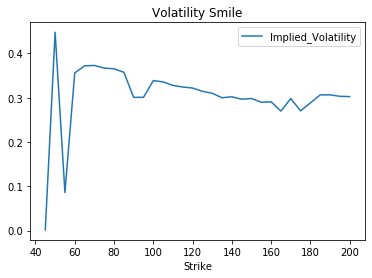

In [161]:
# On garde les Calls de ténor d'environ six mois
iv_strike = Data_Calls_JPM[round(Data_Calls_JPM['Tenor'],1)==1]
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike = iv_strike[['Strike','Implied_Volatility']].set_index('Strike').sort_index()

# On trace le Smile de Volatilité
iv_strike.plot(title = 'Volatility Smile')

Malgré une forte instabilité dans le traage du smile de volatilité due au bruit présent dans les données de marché, nous pouvons ainsi constater pour les strike de ténor d'un an le phénomène de Volatility Skew, c'est à dire une décroissance de la volatilité par rapport au Strike. Cependant, au delà d'un certain Strike, il est hautement probable de pouvoir constater une légère remontée de la volatilité, qui correspond ainsi au Smile de Volatilité. Cela pourrait permettre ainsi de valider les conjectures et affirmations émises pour ces phénomènes, et aussi de confirmer que la volatilité implicite du Call est au plus bas lorsque celui-ci est à la monnaie, et elle augmente au fur et à mesure que le Call s'éloigne de la monnaie.

Par ailleurs, il est possible de tracer la volatilité implicite des Calls de Strike fixé, par exemple à 120, en fonction de leur ténor :

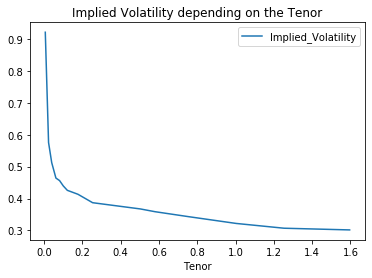

In [102]:
# On garde les Calls de ténor d'environ six mois
iv_tenor = Data_Calls_JPM[Data_Calls_JPM['Strike']==120]
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_tenor = iv_tenor[['Tenor','Implied_Volatility']].set_index('Tenor').sort_index()

# On trace le Smile de Volatilité
iv_tenor.plot(title = 'Implied Volatility depending on the Tenor')

Il est ainsi possible de constater que la volatilité implicite décroit très rapidement en fonction du ténor avant de se stabiliser tout aussi rapidement vers une constante, environ égale à 0.3. Cela corrobore avec la théorie qui stipule que la volatilité implicite est souvent bien plus élevée pour des Calls de maturité courtes que celles de maturité longues, et donc que le phénomène du Smile est davantage marqué pour les options à courtes maturités que pour les longues, et lorsque lorsque la maturité tend vers l'infini, la volatilité tend vers une constante.

Cette différence d'amplitude du phénomène de Smile pourrait être clairement constatée lors du traçage de la nappe de volatilité, où la courbe de volatilité implicite est de plus en plus plate au fur et à mesure que le ténor et donc la maturité, augmente. Malheureusement, il n'a pas été possible de tracer la nappe de volatilité.

### Bonus : pricing du Call par résolution numérique de l'EDP de Black Scholes

Sachant que la dynamique du sous-jacent suit l'EDS : $dS_t = S_t(r dt + \sigma dW_t)$ sous la probabilité risque neutre,

le prix du call selon le modèle de Black Scholes au temps t et de sous-jacent valant $S_t$ : $C_t = C(t, S_t)$ est connu pour suivre l'équation aux dérivée partielles suivante:

$$
\frac{\partial C}{\partial t}(t,S) + rS \frac{\partial C}{\partial S}(t,S) + \frac{1}{2}\sigma \frac{\partial^2 C}{\partial S^2}(t,S) - rC(t,S) = 0
$$

Ce postulat peut être démontré en appliquant directement la formule de Feynman-Kac au prix du Call exprimée sous forme d'espérance des flux futurs actualisés sous la probabilité risque neutre, ou bien en effectuant un calcul d'Itô au prix du portefeuille autofinancant composé du sous-jacent et de l'actif sans risque qui réplique le prix du Call en tout temps, ainsi que sur le prix lui même qui est exprimé sous la forme $C_t = C(t, S)$. L'absence d'opportunité d'arbitrage garantit l'égalité en tout temps du prix du portefeuille ainsi que celui du Call, ce qui permet de retrouver l'EDP par identification.

avec comme condition au bord : $C(T,S) = (S-K)_{+}$, et comme conditions aux limites : $C(t,0) = 0$ et $C(t,S) \sim S - Ke^{-r(T-t)}, \ S \rightarrow \infty$.

#### Transformation de l'EDP de Black Scholes en l'équation de la chaleur

Cependant, cette EDP est difficile à résoudre, et c'est pourquoi il convient d'effectuer un changement de variable pour supprimer les quantités $S$ et $S^2$ devant les dérivées partielles et ainsi retrouver l'équation de la chaleur qui est plus aisée à résoudre.

Pour ce faire, nous posons tout d'abord : $S = Ke^x$,  et $v(x,t) = C(S,t)$.

Ce changement de variable permet d'obtenir les nouvelles dérivées partielles :

$$
\left\{
    \begin{array}{ll}
        \frac{\partial v}{\partial x} =\frac{\partial C}{\partial S} \frac{dS}{dx} = Ke^x \frac{\partial C}{\partial S} = S\frac{\partial C}{\partial S} \\
        \frac{\partial^2 v}{\partial x^2} = Ke^x \frac{\partial C}{\partial S} + Ke^x \frac{\partial^2 C}{\partial S^2} \frac{dS}{dx} = S\frac{\partial C}{\partial S} + S^2\frac{\partial^2 C}{\partial S^2}
    \end{array}
\right.
$$

ce qui permet, en réinjectant ces termes dans l'équation initiale, d'obtenir l'équation suivante :

$$
\frac{\partial v}{\partial t} + \frac{1}{2} \sigma^2 \frac{\partial^2 v}{\partial x^2}  + (r - \frac{1}{2} \sigma^2)  \frac{\partial v}{\partial x} - rv = 0
$$

En posant $\tau = (T-t)\sigma^2$ et $k = \frac{2r}{\sigma^2}$, l'équation ci dessus devient :

$$
\frac{1}{2}\frac{\partial^2 v}{\partial x^2} + \frac{1}{2}(k-1)\frac{\partial v}{\partial x} - \frac{1}{2}kv = \frac{\partial v}{\partial \tau}
$$

Sachant que l'EDP précédente a pour équation caractéristique : $\alpha^2 + (k-1)\alpha-k$, il est possible de poser $\alpha$ tel que $2\alpha + (k-1) =0$ et $\beta$ tel que $\beta = \alpha^2 + (k-1)\alpha-k$, pour ainsi effectuer le changement de variable suivant : $v(x,\tau) = e^{\alpha x + \beta \tau}u(x,\tau)$, permettant ainsi d'obtenir les dérivées partielles suivantes:

$$
\left\{
    \begin{array}{lll}
        \frac{\partial v}{\partial x} = \alpha e^{\alpha x + \beta \tau} u(x,\tau) + e^{\alpha x + \beta \tau} \frac{\partial u}{\partial x}(x,\tau) \\
        \frac{\partial^2 v}{\partial x^2} = \alpha^2 e^{\alpha x + \beta \tau} u(x,\tau) + 2\alpha e^{\alpha x + \beta \tau} \frac{\partial u}{\partial x}(x,\tau) + e^{\alpha x + \beta \tau} \frac{\partial^2 u}{\partial x^2}(x,\tau) \\
        \frac{\partial v}{\partial \tau} = \beta e^{\alpha x + \beta \tau} u(x,\tau) + e^{\alpha x + \beta \tau} \frac{\partial u}{\partial \tau}(x,\tau)
    \end{array}
\right.
$$

De ce fait, l'équation suivante est obtenue :

$$
- \frac{\partial u}{\partial \tau} + \frac{1}{2}\frac{\partial^2 u}{\partial x^2} + (\alpha + \frac{1}{2}(k-1))\frac{\partial u}{\partial x} + (-\beta + \frac{1}{2}\alpha^2 + \frac{1}{2}\beta(k-1) - \frac{1}{2}k)u = 0
$$

Or, $\alpha = \frac{1}{2}(1-k)$ et $\beta = \alpha^2 + (k-1)\alpha-k= \frac{1}{8}(1+k)^2$,

ce qui permet ainsi de conclure que u suit l'équation de la chaleur :

$$
\frac{\partial u}{\partial \tau} - \frac{1}{2} \frac{\partial^2 u}{\partial x^2} = 0
$$

avec $\tau \in [0, \frac{1}{2}\sigma^2T]$ et $x \in \mathbb{R}$.

La condition initiale de cette équation de la chaleur est donnée par : $u(x,0) = e^{-\alpha x} (K - Ke^x)_{+} = Ke^{-\alpha x}(1 - e^x)_{+}$.

Et de même, par changement de variable, les conditions aux bords sont données par : $\lim\limits_{x \rightarrow -\infty} C(\tau,x) = 0$ et $C(\tau,x) \sim e^x- Ke^{-r\tau}, \ x \rightarrow \infty$.

L'équation finale à résoudre ayant été posée, le schéma choisi pour la résolution numérique est celui de Crank Nicholson. Avant cela, un paragraphe est consacré à la méthode des différences finies.

#### Méthodes des différences finies

Rappelons que pour différentier une dérivée partielle, trois méthodes de différences finies peuvent être utilisées :

- $\frac{\partial u(x,\tau)}{\partial x} \approx \frac{u(x+\delta x, \tau) - u(x,\tau)}{\delta x}$ : différence progressive
- $\frac{\partial u(x,\tau)}{\partial x} \approx \frac{u(x,\tau) - u(x-\delta x, \tau)}{\delta x}$ : différence rétrograde
- $\frac{\partial u(x,\tau)}{\partial x} \approx \frac{u(x+\delta x, \tau) - u(x-\delta x,\tau)}{2\delta x}$ : différence centrée

, avec $\delta x$ et $\delta \tau$ les intervalles de temps selon les différentes variables.

Et pour les dérivés secondes, la méthode des différences finies centrées est :

$\frac{\partial^2 u(x,\tau)}{\partial x^2} \approx \frac{u(x+\delta x, \tau) - u(x-\delta x, \tau) - 2 u(x,\tau)}{\delta x^2}$

#### Résolution par le schéma de Crank Nicolson

La résolution numérique de l'équation de la chaleur commence par la discrétisation de l'espace de définition des deux variables $x$ et $\tau$, selon un pas spatiale $\delta x$ et un pas de temps $\delta t$. De ce fait, les dérivés partielles aux points $(x_n, \tau_m)$. Nous définissons ainsi $u_{n,m} = u(n\delta x, m\delta \tau)$.

La condition au bord est donc $u_{n,0} = u(n\delta x, 0) = Ke^{-\alpha n\delta x}(1 - e^{n\delta x})_{+}$ et les conditions aux limites sont : $u_{N^{-},m} = u(N^{-}\delta x, m\delta \tau)$ et $u_{N^{+},m} = u(N^{+}\delta x, m\delta \tau)$, avec $N^{-}$ et $N^{+}$ définis tels que $N^{-} \leq n \leq N^{+}$. En parallèle, nous posons $M^{+}$ tel que $0 \leq m \leq M^{+}$

De ce fait, la discrétisation de l'espace permet d'évoquer deux premières possibilités de résolution de l'équation de la chaleur. La première serait d'utiliser le schéma d'Euler explicite : à partir de cette discrétisation et de la nouvelle variable déclarée, l'équation de la chaleur est résolu par une différence finie décentrée à droite :

$$
\frac{u_{n,m+1}-u_{n,m}}{\delta \tau} \approx \frac{1}{2}\frac{u_{n-1,m} - 2 u_{n,m} + u_{n+1,m}}{\delta x^2}
$$

La deuxième possibilité est le schéma d'Euler implicite, consistant à effectuer une différence finie décentrée à gauche :

$$
\frac{u_{n,m+1}-u_{n,m}}{\delta \tau} \approx \frac{1}{2}\frac{u_{n-1,m+1} - 2 u_{n,m+1} + u_{n+1,m+1}}{\delta x^2}
$$

En déterminant les conditions aux bords et aux limites sur l'espace discrétisé puis en posant $\alpha = \frac{\delta \tau}{\delta x^2}$ qui doit être strictement inférieur à 0.5 pour répondre aux conditions de stabilité, on montre que le problème initial se transforme en un système linéaire du type : $AU^{m+1} = b^m$ avec $U^{m+1}$ un vecteur contenant les variables $u_{n,m+1}$ avec $m+1$ fixé, et $b^m$ le second membre qui est connu

Ce système est résolvable numériquement par la méthode du pivot de Gauss.


Cependant, la méthode qui fournit la solution la plus stable et la plus précise semble être le schéma de Crank Nicolson, qui consiste en un schéma aux différences finis centré en espace. Il s'agit d'une moyenne des schémas d'Euler explicite et implicite. De ce fait, l'équation de la chaleur devient :

$$
\frac{u_{n,m+1}-u_{n,m}}{\delta \tau} \approx \frac{1}{4}(\frac{u_{n-1,m} - 2 u_{n,m} + u_{n+1,m}}{\delta x^2}+ \frac{u_{n-1,m+1} - 2 u_{n,m+1} + u_{n+1,m+1}}{\delta x^2})
$$

En posant $\alpha = \frac{\delta \tau}{\delta x^2}$, l'équation précédente devient :

$$
u_{n,m+1} - \frac{1}{4} \alpha (u_{n-1,m+1} - 2 u_{n,m+1} + u_{n+1,m+1}) = u_{n,m} + \frac{1}{4} \alpha(u_{n-1,m} - 2 u_{n,m} + u_{n+1,m})
$$

En supposant que les quantités $u_{n,m}$ sont connus pour un $m$ fixé et sachant que les conditions aux limites sont connues, il est possible de transformer l'équation précédente en un système linéaire, étant donné que l'on souhaite calculer tous les $u_{n,m+1}$, avec $m$ fixé. Le système linéaire est exprimé sous la forme :

$$
CU^{m+1} = b^m
$$

Avec : 

$$
U^{m+1} = \begin{pmatrix} u_{N^{-}+1, m+1} \\ \vdots \\ u_{0, m+1} \\ \vdots  \\ u_{N^{+}-1, m+1}\end{pmatrix}
$$

$$
C = \begin{pmatrix}
    1+\frac{1}{2}\alpha & -\frac{1}{4}\alpha & 0 & \cdots & 0 \\ 
    -\frac{1}{4}\alpha & 1+\frac{1}{2}\alpha & -\frac{1}{4}\alpha & \cdots & 0 \\ 
    0 & -\frac{1}{4}\alpha & \ddots & \ddots &  \\ 
    \vdots &  & \ddots & \ddots & -\frac{1}{4}\alpha \\ 
    0 & 0 &  & -\frac{1}{4}\alpha & 1+\frac{1}{2}\alpha \\ 
\end{pmatrix}
$$

et :
$$
b^m = \begin{pmatrix} f_{N^{-}+1, m} \\ \vdots \\ f_{0, m} \\ \vdots  \\ f_{N^{+}-1, m}\end{pmatrix} + \frac{1}{4}\alpha \begin{pmatrix} u_{N^{-}, m+1} \\ 0 \\ \vdots \\ 0 \\ u_{N^{+}, m+1}\end{pmatrix}
$$

avec : 

$$
f_{n, m} = (1- \frac{1}{2}\alpha) u_{n, m} + \frac{1}{4}\alpha(u_{n-1, m}+u_{n+1, m})
$$

Le calcul du prix d'un Call selon le modèle de Black Scholes passe donc par la résolution de ce système linéaire, en rappelant que la condition au bord est $u_{n,0} = u(n\delta x, 0) = Ke^{-\alpha n\delta x}(1 - e^{n\delta x})_{+}$ et les conditions aux limites sont : $u_{N^{-},m} = u(N^{-}\delta x, m\delta \tau) = 0$ et $u_{N^{+},m} = u(N^{+}\delta x, m\delta \tau) = e^{N^{+}\delta x}$.

Rappelons par ailleurs que $S = Ke^x$ donc $x = ln(\frac{S}{K})$ et que $\tau = (T-t)\sigma^2$.

In [393]:
## Implémentation de la méthode.

Cependant, les résultats obtenus ne sont pas satisfaisants, à cause d'erreur de programmation ou de spécification du problème. Il a donc été convenu d'utiliser une autre approche.

#### Autre approche utilisée

En reprenant l'EDP de Black Scholes à laquelle le changement de variable $S = Ke^x$,  et $v(x,t) = C(S,t)$ a été effectué afin de supprimer les quantités $S$ et $S^2$, l'EDP transformé est, selon la démonstration effectuée au début de la partie concernée :

$$
\frac{\partial v}{\partial t} + (r - \frac{1}{2} \sigma^2)  \frac{\partial v}{\partial x} + \frac{1}{2} \sigma^2 \frac{\partial^2 v}{\partial x^2} - rv = 0
$$

La condition terminale est $v(x,T) = (e^x - K)_{+}$,

et les conditions aux bords sont : $\lim\limits_{x \rightarrow -\infty} v(t,x) = 0$ et $v(t,x) \sim e^x- Ke^{-r(T-t)}, \ x \rightarrow \infty$.

L'idée de l'approche précédente était d'effectuer un autre changement de variable $\tau = (T-t)\sigma^2$ afin d'obtenir l'équation de la chaleur, mais il a été décidé d'exploiter directement l'équation aux dérivées partielles définie ci dessus.

Afin de résoudre numériquement l'équation, le schéma d'Euler implicite, reconnue comme plus stable que celui explicite, a été utilisé au lieu du schéma de Crank Nicolson.

#### Schéma implicite

Comme convenu, l'espace de définition des deux variables $x$ et $\tau$ est discrétisé selon un pas spatiale $\delta x$ et un pas de temps $\delta t$. De ce fait, les dérivés partielles aux points $(x_n, \tau_m)$. Nous définissons ainsi $v_{n,m} = v(n\delta x, m\delta \tau)$.

La condition au bord est donc $v_{n,0} = v(n\delta x, 0) = (e^{-\alpha n\delta x} - K)_{+}$ et les conditions aux limites sont : $v_{N^{-},m} = v(N^{-}\delta x, m\delta \tau)$ et $v_{N^{+},m} = v(N^{+}\delta x, m\delta \tau)$, avec $N^{-}$ et $N^{+}$ définis tels que $N^{-} \leq n \leq N^{+}$. En parallèle, nous posons $M^{+}$ tel que $0 \leq m \leq M^{+}$.

Le schéma d'Euler implicite peut être appliqué pour obtenir la version discrétisée de l'équation aux dérivées partielles :

$$
\frac{v_{n,m+1}-v_{n,m}}{\delta t} + (r - \frac{1}{2} \sigma^2) \frac{v_{n+1,m}-v_{n-1,m}}{2\delta x} + \frac{1}{2}\frac{v_{n-1,m} - 2 v_{n,m} + v_{n+1,m}}{\delta x^2} \approx  0
$$,

Ce qui donne :

$$
v_{n,m+1} \approx v_{n-1,m}((r - \frac{1}{2} \sigma^2) \frac{\delta t}{2\delta x} + \frac{1}{2} \sigma^2\frac{\delta t}{\delta x^2}) + v_{n,m}(1 + r \delta t + \sigma^2 \frac{\delta t}{\delta x^2}) + v_{n+1,m}(-(r - \frac{1}{2} \sigma^2) \frac{\delta t}{2\delta x} + \frac{1}{2} \sigma^2\frac{\delta t}{\delta x^2})
$$.

Ainsi, en posant :

$a = (r - \frac{1}{2} \sigma^2) \frac{\delta t}{2\delta x} + \frac{1}{2} \sigma^2\frac{\delta t}{\delta x^2}$

$b = 1 + r \delta t + \sigma^2 \frac{\delta t}{\delta x^2}$

$c = -(r - \frac{1}{2} \sigma^2) \frac{\delta t}{2\delta x} + \frac{1}{2} \sigma^2\frac{\delta t}{\delta x^2}$,

il est possible d'obtenir :

$$
v_{n,m+1} \approx a v_{n-1,m} + b v_{n,m} + c v_{n+1,m}
$$,

ce qui permet finalement de transformer l'equation aux dérivées partielles de départ en un système linéaire pouvant être exprimé comme suit :

$$
V^{m+1} = C V^m + b^m
$$

Avec : 

$$
V^{m} = \begin{pmatrix} V_{N^{-}+1, m} \\ \vdots \\ v_{0, m} \\ \vdots  \\ v_{N^{+}-1, m}\end{pmatrix}
$$

donc 

$$
V^{m+1} = \begin{pmatrix} u_{N^{-}+1, m+1} \\ \vdots \\ v_{0, m+1} \\ \vdots  \\ v_{N^{+}-1, m+1}\end{pmatrix}
$$

$$
C = \begin{pmatrix}
    b & c & 0 & \cdots & 0 \\ 
    a & b & c & \cdots & 0 \\ 
    0 & \ddots & \ddots & \ddots & \vdots  \\ 
    \vdots & 0 & a & b & c \\ 
    0 & 0 &  & b & c \\ 
\end{pmatrix}
$$

et :
$$
b^m = \begin{pmatrix} v_{N^{-}, m} \\ 0 \\ \vdots \\ 0 \\ v_{N^{+}, m}\end{pmatrix}
$$

Ainsi, le système linéaire peut donc directement être résolu numériquement. Pour cela, dans un premier temps, on initialise les paramètres :

In [382]:
r = 0.1 
sig = 0.2                
S0 = 100 
X0 = np.log(S0)          
K = 100
T = 1

Par la suite, nous discrétisons les espaces de variables $x = log(S)$ et $t$ selon respectivement 3000 pas d'espaces et 2000 pas de temps. Il est par ailleurs coutume de prendre comme valeurs minimales spatiaux $S_{min} = K/3$ et $S_{max} = 3K$, ainsi que $t_0 = 0$ et $t_max = T$.

In [388]:
Nspace = 3000 
Ntime = 2000   

S_max = 3*float(K)                
S_min = float(K)/3

x_max = np.log(S_max)
x_min = np.log(S_min)

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)
t, dt = np.linspace(0, T, Ntime, retstep=True)

Ainsi, la matrice $V$ de l'ensemble des prix des Calls en fonction du log du sous-jacent $x$ et du temps $t$, et le vecteur $b$ de l'équation sont initialisés et les conditions au bords et terminales sont spécifiées.

In [389]:
# initialisation
V = np.zeros((Nspace,Ntime))    
bm = np.zeros(Nspace-2)           

# condition terminale
Payoff = np.maximum(np.exp(x)-K,0)
V[:,-1] = Payoff           

# conditions aux bords
V[-1,:] = np.exp(x_max) - K * np.exp(-r* t[::-1] )  
V[0,:] = 0    

La matrice $C$ du système linéaire est par la suite spécifiée selon ses termpes $a$, $b$ et $c$ :

In [390]:
# Spécification de la matrice C
sig2 = sig*sig; dxx = dx * dx

a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )

C = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()

Le système linéaire est finalement résolu numériquement :

In [391]:
# Résolution du système linéaire
for i in range(Ntime-2,-1,-1):
    bm[0] = a * V[0,i]
    bm[-1] = c * V[-1,i]; 
    V[1:-1,i] = spsolve( C, (V[1:-1,i+1] - bm) )

Ainsi, il est possible dans un premier temps de tracer le prix actuel du Call ainsi que son PayOff en fonction du prix de son sous-jacent, et dans un second temps de tracer le prix du Call en fonction de celui du sous-jacent et du temps $t$ :

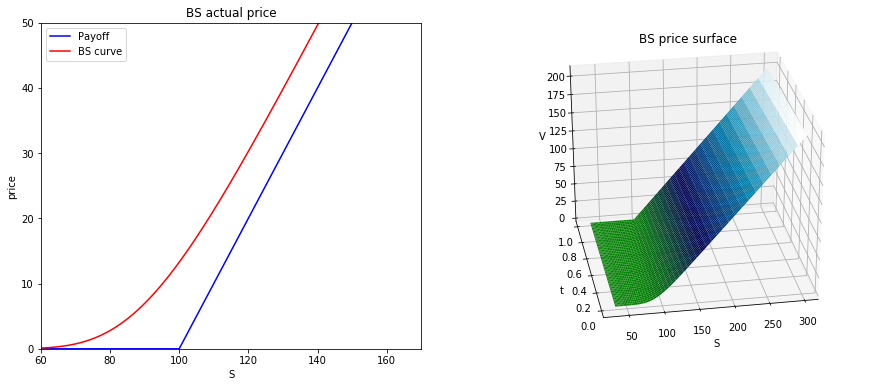

In [392]:
S = np.exp(x)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="BS curve")
ax1.set_xlim(60,170); ax1.set_ylim(0,50)
ax1.set_xlabel("S"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS actual price")

X, Y = np.meshgrid(t, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

Ainsi, il est possible de constater le prix actuel du Call en fonction de celui du sous-jacent, dont la forme est bien connue. Au fur et à mesure que le temps progresse, la courbe de prix se rapproche progressivement de la valeur du Pay-Off, avant d'en être égale à maturité, comme il est possible de constater sur le second graphique.